<a href="https://colab.research.google.com/github/abyaadrafid/Deep-Reinforcement-Learning/blob/master/Double_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 43 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,

In [0]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from google.colab import drive 
%matplotlib inline

plt.style.use('seaborn')

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(8,)


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
class DQN(nn.Module):
    def __init__(self, state_size, fc1_size, fc2_size, action_size, seed):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, action_size)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [0]:
class ReplayMemory():
    def __init__(self, buffer_size, batch_size, seed):
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add_experience(self, state, action, reward, next_state, done):
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
                
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [0]:
EPS_START = 1.0    
EPS_DECAY = 0.999    
EPS_MIN = 0.01

In [0]:
TAU = 1e-3              
LR = 1e-4        
GAMMA = 0.99           
UPDATE_EVERY = 4      
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64

In [0]:
FC1_SIZE = 128
FC2_SIZE = 256   
    
MAX_EPISODES = 2000  
MAX_STEPS = 1000     
ENV_SOLVED = 200    
PRINT_EVERY = 100

In [0]:
class DoubleDeepQAgent():
  def __init__(self, state_size, fc1_size, fc2_size, action_size, seed = 0):
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.q_network = DQN(self.state_size, fc1_size, fc2_size, self.action_size, seed).to(device)
    self.target_network = DQN(self.state_size, fc1_size, fc2_size, self.action_size, seed).to(device)
    self.optimizer = optim.Adam(self.q_network.parameters())

    self.memory = ReplayMemory(BUFFER_SIZE, BATCH_SIZE, seed)
    self.timestep =0

  def step(self, state, action, reward, next_state, done):
    self.memory.add_experience(state, action, reward, next_state, done)
    self.timestep +=1
    if self.timestep % UPDATE_EVERY == 0:
      if len(self.memory) > BATCH_SIZE:
        sampled_experience = self.memory.sample()
        self.learn(sampled_experience)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences 
    
    Q_output = self.q_network(states).gather(1, actions)
    action_values = self.q_network(next_states).detach()

    target_action_values = self.target_network(next_states).detach()
    max_action_indices = target_action_values.max(1)[1].unsqueeze(1)
    max_action_values = action_values.gather(1, max_action_indices)
    
    Q_target = rewards + GAMMA * max_action_values * (1 - dones)

    loss = F.mse_loss(Q_output, Q_target)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.update_target_network(self.q_network, self.target_network)

  def update_target_network(self, source_network, target_network):
    for source_parameters, target_parameters in zip(source_network.parameters(), target_network.parameters()):
      target_parameters.data.copy_(TAU * source_parameters.data + (1- TAU) * target_parameters.data)

  def act(self, state, eps=0.0):
    rnd = random.random()
    if rnd < eps:
      return np.random.randint(self.action_size)
    else:
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)

      self.q_network.eval()
      with torch.no_grad():
        action_values = self.q_network(state)

      self.q_network.train()
      action = np.argmax(action_values.cpu().data.numpy())
      return action    
        
  def checkpoint(self, filename):
    torch.save(self.q_network.state_dict(), filename)

In [30]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('State size: {}, action size: {}'.format(state_size, action_size))

State size: 8, action size: 4


In [0]:
def train(dqn_agent):
  start = time()
  scores = []

  scores_window = deque(maxlen=100)
  eps = EPS_START
  for episode in range(1, MAX_EPISODES + 1):
      state = env.reset()
      score = 0
      for t in range(MAX_STEPS):
          action = dqn_agent.act(state, eps)
          next_state, reward, done, info = env.step(action)
          dqn_agent.step(state, action, reward, next_state, done)
          state = next_state        
          score += reward        
          if done:
              break
              
          eps = max(eps * EPS_DECAY, EPS_MIN)
          if episode % PRINT_EVERY == 0:
              mean_score = np.mean(scores_window)
              print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
          if score >= ENV_SOLVED:
              mean_score = np.mean(scores_window)
              print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
              sys.stdout.flush()
              dqn_agent.checkpoint('solved_200.pth')
              break
              
      scores_window.append(score)
      scores.append(score)
      
  end = time()    
  print('Took {} seconds'.format(end - start))

  return scores

In [0]:
ddqn_agent = DoubleDeepQAgent(state_size, FC1_SIZE, FC2_SIZE, action_size, seed=0)

In [33]:
ddqn_scores = train(ddqn_agent)

 Progress 2000/2000, average score:237.88Took 1511.2278230190277 seconds


In [0]:
def plot(score, string):
  plt.figure(figsize=(10,6))
  plt.plot(score)
  plt.plot(pd.Series(score).rolling(100).mean())
  plt.title('%s Training,'%string)
  plt.xlabel('# of episodes')
  plt.ylabel('score')
  plt.show()

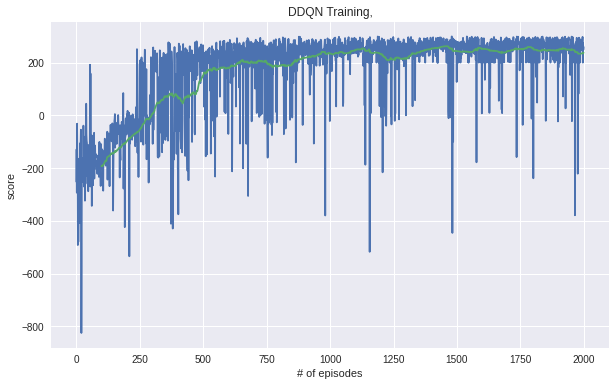

In [35]:
plot(ddqn_scores, 'DDQN')